# Zero-Shot Property Scoring - Visual Analysis

This notebook performs zero-shot property condition scoring using Vision Language Models (VLMs) without any examples.

We'll:
1. Load annotations and scoring prompt
2. Run scoring with different VLM providers
3. Compare predictions vs ground truth
4. Visualize results with confusion matrices and distributions


In [25]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, Markdown
from src.data_loader import DataLoader
from src.providers import get_provider
from src.config import Config

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [26]:
# Load annotations
loader = DataLoader()
df = loader.load_annotations()

# Filter to only images with expert scores
scored_df = df[df['expert_score'].notna()].copy()
scored_df['expert_score'] = scored_df['expert_score'].astype(int)

# Filter to existing images
scored_df = scored_df[scored_df['image_path'].apply(os.path.exists)]

print(f"📊 Total images with expert scores: {len(scored_df)}")
print(f"\n📊 Score distribution:")
print(scored_df['expert_score'].value_counts().sort_index())

# Sample for testing (use all for full run)
SAMPLE_SIZE = 20  # Change to None to use all images
if SAMPLE_SIZE:
    scored_df = scored_df.sample(n=min(SAMPLE_SIZE, len(scored_df)), random_state=42)
    print(f"\n🎲 Using sample of {len(scored_df)} images for testing")


📊 Total images with expert scores: 1686

📊 Score distribution:
expert_score
1    211
2    544
3    607
4    283
5     41
Name: count, dtype: int64

🎲 Using sample of 20 images for testing


In [27]:
# Load scoring prompt
prompt_path = os.path.join(Config.PROMPTS_DIR, "prompt_zero_shot.txt")
with open(prompt_path, "r") as f:
    scoring_prompt = f.read()

print("Scoring Prompt (first 500 chars):")
print("=" * 80)
print(scoring_prompt[:500] + "...")
print("=" * 80)


Scoring Prompt (first 500 chars):
Neighborhood House Scoring Prompt (No Average Rule)
Overview
You are an expert housing-condition inspector. Analyze the provided house photo and output ONLY JSON (no prose). Use the rubric below and the exact schema and ordering.
Subcategories to score (1–5 each)
Score each with a number and a one-sentence explanation:
 1) general_exterior_condition — paint/siding cleanliness, damage, visible grime.
 2) porch_entryway — steps, railings, porch floor/stoop condition & tidiness.
 3) landscaping — l...


In [28]:
def extract_score_from_response(response):
    """Extract score from VLM response"""
    if not response:
        return None
    
    try:
        # Try to find JSON in response
        if "```json" in response:
            json_str = response.split("```json")[1].split("```")[0].strip()
            parsed = json.loads(json_str)
            return parsed.get("score") or parsed.get("overall_score")
        elif "{" in response and "score" in response.lower():
            # Try to extract JSON object
            json_match = re.search(r'\{[^{}]*"score"[^{}]*\}', response)
            if json_match:
                parsed = json.loads(json_match.group())
                return parsed.get("score")
        
        # Try to find score number
        score_match = re.search(r'"score"\s*:\s*(\d)', response, re.IGNORECASE)
        if score_match:
            return int(score_match.group(1))
        
        # Try to find standalone score
        score_match = re.search(r'\bscore[:\s]+(\d)\b', response, re.IGNORECASE)
        if score_match:
            return int(score_match.group(1))
        
        # Try to find number 1-5
        score_match = re.search(r'\b([1-5])\b', response)
        if score_match:
            return int(score_match.group(1))
    except:
        pass
    
    return None


In [29]:
# Test with different providers
providers_to_test = ["local", "openai", "google", "together"]  # Add/remove as needed
results_by_provider = {}

for provider_name in providers_to_test:
    print(f"\n{'='*60}")
    print(f"Testing {provider_name.upper()} provider")
    print(f"{'='*60}")
    
    try:
        provider = get_provider(provider_name)
        print(f"✅ Model: {provider.model_name}")
        
        results = []
        for idx, (_, row) in enumerate(scored_df.iterrows(), 1):
            img_path = row['image_path']
            expert_score = row['expert_score']
            
            if idx % 10 == 0:
                print(f"  Progress: {idx}/{len(scored_df)}")
            
            try:
                response = provider.analyze(img_path, scoring_prompt)
                predicted_score = extract_score_from_response(response)
                
                results.append({
                    "image_path": img_path,
                    "file_name": os.path.basename(img_path),
                    "expert_score": expert_score,
                    "predicted_score": predicted_score,
                    "provider": provider_name,
                    "model": provider.model_name,
                    "raw_response": response[:200] if response else None
                })
            except Exception as e:
                results.append({
                    "image_path": img_path,
                    "file_name": os.path.basename(img_path),
                    "expert_score": expert_score,
                    "predicted_score": None,
                    "provider": provider_name,
                    "error": str(e)
                })
        
        results_by_provider[provider_name] = pd.DataFrame(results)
        print(f"✅ Completed {provider_name}: {len(results)} images processed")
        
    except Exception as e:
        print(f"❌ Error with {provider_name}: {e}")
        continue



Testing LOCAL provider
✅ Model: gemma3:27b


  Progress: 10/20
  Progress: 20/20
✅ Completed local: 20 images processed

Testing OPENAI provider
✅ Model: gpt-4o
  Progress: 10/20
  Progress: 20/20
✅ Completed openai: 20 images processed

Testing GOOGLE provider
✅ Model: gemini-3-pro-preview
  Progress: 10/20
  Progress: 20/20
✅ Completed google: 20 images processed

Testing TOGETHER provider
✅ Model: Qwen/Qwen2.5-VL-72B-Instruct
  Progress: 10/20
  Progress: 20/20
✅ Completed together: 20 images processed


In [30]:
# Display results for each provider
for provider_name, results_df in results_by_provider.items():
    print(f"\n{'='*60}")
    print(f"{provider_name.upper()} Results")
    print(f"{'='*60}")
    display(results_df.head(10))
    
    # Statistics
    valid_predictions = results_df[results_df['predicted_score'].notna()]
    if len(valid_predictions) > 0:
        print(f"\n✅ Valid predictions: {len(valid_predictions)}/{len(results_df)}")
        print(f"📊 Predicted score distribution:")
        print(valid_predictions['predicted_score'].value_counts().sort_index())



LOCAL Results


,image_path,file_name,expert_score,predicted_score,provider,model,raw_response
0,/home/exouser/DSM-property-condition-assessmen...,ATT136_PropertyConditionAssessment_image-20220...,2,3,local,gemma3:27b,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
1,/home/exouser/DSM-property-condition-assessmen...,ATT59623_PropertyConditionAssessment_image-202...,1,3,local,gemma3:27b,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
2,/home/exouser/DSM-property-condition-assessmen...,ATT35903_PropertyConditionAssessment_image-202...,2,3,local,gemma3:27b,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
3,/home/exouser/DSM-property-condition-assessmen...,ATT3787_PropertyConditionAssessment_image-2022...,2,3,local,gemma3:27b,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
4,/home/exouser/DSM-property-condition-assessmen...,ATT3065_PropertyConditionAssessment_image-2022...,2,3,local,gemma3:27b,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
5,/home/exouser/DSM-property-condition-assessmen...,ATT8273_PropertyConditionAssessment_image-2022...,3,3,local,gemma3:27b,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
6,/home/exouser/DSM-property-condition-assessmen...,ATT6973_PropertyConditionAssessment_image-2022...,2,2,local,gemma3:27b,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
7,/home/exouser/DSM-property-condition-assessmen...,ATT61246_PropertyConditionAssessment_image-202...,3,3,local,gemma3:27b,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
8,/home/exouser/DSM-property-condition-assessmen...,ATT8988_PropertyConditionAssessment_image-2022...,4,3,local,gemma3:27b,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
9,/home/exouser/DSM-property-condition-assessmen...,ATT60710_PropertyConditionAssessment_image-202...,2,3,local,gemma3:27b,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."



✅ Valid predictions: 20/20
📊 Predicted score distribution:
predicted_score
2     2
3    18
Name: count, dtype: int64

OPENAI Results


,image_path,file_name,expert_score,predicted_score,provider,model,raw_response
0,/home/exouser/DSM-property-condition-assessmen...,ATT136_PropertyConditionAssessment_image-20220...,2,3.0,openai,gpt-4o,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
1,/home/exouser/DSM-property-condition-assessmen...,ATT59623_PropertyConditionAssessment_image-202...,1,1.0,openai,gpt-4o,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."
2,/home/exouser/DSM-property-condition-assessmen...,ATT35903_PropertyConditionAssessment_image-202...,2,1.0,openai,gpt-4o,"{\n ""file"": null,\n ""subscores"": {\n ""..."
3,/home/exouser/DSM-property-condition-assessmen...,ATT3787_PropertyConditionAssessment_image-2022...,2,1.0,openai,gpt-4o,"{\n ""file"": ""null"",\n ""subscores"": {\n ""g..."
4,/home/exouser/DSM-property-condition-assessmen...,ATT3065_PropertyConditionAssessment_image-2022...,2,NaN,openai,gpt-4o,"```json\n{\n ""file"": null,\n ""subscores"": {\..."
5,/home/exouser/DSM-property-condition-assessmen...,ATT8273_PropertyConditionAssessment_image-2022...,3,NaN,openai,gpt-4o,"```json\n{\n ""file"": null,\n ""subscores"": {\..."
6,/home/exouser/DSM-property-condition-assessmen...,ATT6973_PropertyConditionAssessment_image-2022...,2,2.0,openai,gpt-4o,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."
7,/home/exouser/DSM-property-condition-assessmen...,ATT61246_PropertyConditionAssessment_image-202...,3,2.0,openai,gpt-4o,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."
8,/home/exouser/DSM-property-condition-assessmen...,ATT8988_PropertyConditionAssessment_image-2022...,4,3.0,openai,gpt-4o,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."
9,/home/exouser/DSM-property-condition-assessmen...,ATT60710_PropertyConditionAssessment_image-202...,2,1.0,openai,gpt-4o,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."



✅ Valid predictions: 18/20
📊 Predicted score distribution:
predicted_score
1.0     5
2.0     2
3.0    10
4.0     1
Name: count, dtype: int64

GOOGLE Results


,image_path,file_name,expert_score,predicted_score,provider,model,raw_response
0,/home/exouser/DSM-property-condition-assessmen...,ATT136_PropertyConditionAssessment_image-20220...,2,1,google,gemini-3-pro-preview,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."
1,/home/exouser/DSM-property-condition-assessmen...,ATT59623_PropertyConditionAssessment_image-202...,1,1,google,gemini-3-pro-preview,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."
2,/home/exouser/DSM-property-condition-assessmen...,ATT35903_PropertyConditionAssessment_image-202...,2,1,google,gemini-3-pro-preview,"```json\n{\n ""file"": null,\n ""subscores"": {\..."
3,/home/exouser/DSM-property-condition-assessmen...,ATT3787_PropertyConditionAssessment_image-2022...,2,1,google,gemini-3-pro-preview,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."
4,/home/exouser/DSM-property-condition-assessmen...,ATT3065_PropertyConditionAssessment_image-2022...,2,1,google,gemini-3-pro-preview,"```json\n{\n ""file"": null,\n ""subscores"": {\..."
5,/home/exouser/DSM-property-condition-assessmen...,ATT8273_PropertyConditionAssessment_image-2022...,3,2,google,gemini-3-pro-preview,"```json\n{\n ""file"": null,\n ""subscores"": {\..."
6,/home/exouser/DSM-property-condition-assessmen...,ATT6973_PropertyConditionAssessment_image-2022...,2,1,google,gemini-3-pro-preview,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."
7,/home/exouser/DSM-property-condition-assessmen...,ATT61246_PropertyConditionAssessment_image-202...,3,2,google,gemini-3-pro-preview,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."
8,/home/exouser/DSM-property-condition-assessmen...,ATT8988_PropertyConditionAssessment_image-2022...,4,3,google,gemini-3-pro-preview,"```json\n{\n ""file"": null,\n ""subscores"": {\..."
9,/home/exouser/DSM-property-condition-assessmen...,ATT60710_PropertyConditionAssessment_image-202...,2,1,google,gemini-3-pro-preview,"{\n ""file"": null,\n ""subscores"": {\n ""gen..."



✅ Valid predictions: 20/20
📊 Predicted score distribution:
predicted_score
1    12
2     6
3     1
4     1
Name: count, dtype: int64

TOGETHER Results


,image_path,file_name,expert_score,predicted_score,provider,model,raw_response
0,/home/exouser/DSM-property-condition-assessmen...,ATT136_PropertyConditionAssessment_image-20220...,2,2,together,Qwen/Qwen2.5-VL-72B-Instruct,"{\n ""file"": ""ATT7501_PropertyConditionAssess..."
1,/home/exouser/DSM-property-condition-assessmen...,ATT59623_PropertyConditionAssessment_image-202...,1,2,together,Qwen/Qwen2.5-VL-72B-Instruct,"{\n ""file"": ""ATT7501_PropertyConditionAssess..."
2,/home/exouser/DSM-property-condition-assessmen...,ATT35903_PropertyConditionAssessment_image-202...,2,1,together,Qwen/Qwen2.5-VL-72B-Instruct,"{\n ""file"": ""ATT7501_PropertyConditionAssess..."
3,/home/exouser/DSM-property-condition-assessmen...,ATT3787_PropertyConditionAssessment_image-2022...,2,2,together,Qwen/Qwen2.5-VL-72B-Instruct,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
4,/home/exouser/DSM-property-condition-assessmen...,ATT3065_PropertyConditionAssessment_image-2022...,2,1,together,Qwen/Qwen2.5-VL-72B-Instruct,"{\n ""file"": ""ATT7501_PropertyConditionAssessm..."
5,/home/exouser/DSM-property-condition-assessmen...,ATT8273_PropertyConditionAssessment_image-2022...,3,2,together,Qwen/Qwen2.5-VL-72B-Instruct,"{\n ""file"": ""ATT7501_PropertyConditionAssess..."
6,/home/exouser/DSM-property-condition-assessmen...,ATT6973_PropertyConditionAssessment_image-2022...,2,1,together,Qwen/Qwen2.5-VL-72B-Instruct,"```json\n{\n ""file"": ""ATT7501_PropertyConditi..."
7,/home/exouser/DSM-property-condition-assessmen...,ATT61246_PropertyConditionAssessment_image-202...,3,3,together,Qwen/Qwen2.5-VL-72B-Instruct,"{\n ""file"": ""ATT7501_PropertyConditionAssess..."
8,/home/exouser/DSM-property-condition-assessmen...,ATT8988_PropertyConditionAssessment_image-2022...,4,3,together,Qwen/Qwen2.5-VL-72B-Instruct,"{\n ""file"": null,\n ""subscores"": {\n ""..."
9,/home/exouser/DSM-property-condition-assessmen...,ATT60710_PropertyConditionAssessment_image-202...,2,1,together,Qwen/Qwen2.5-VL-72B-Instruct,"{\n ""file"": ""ATT7501_PropertyConditionAssess..."



✅ Valid predictions: 20/20
📊 Predicted score distribution:
predicted_score
1     4
2    12
3     4
Name: count, dtype: int64


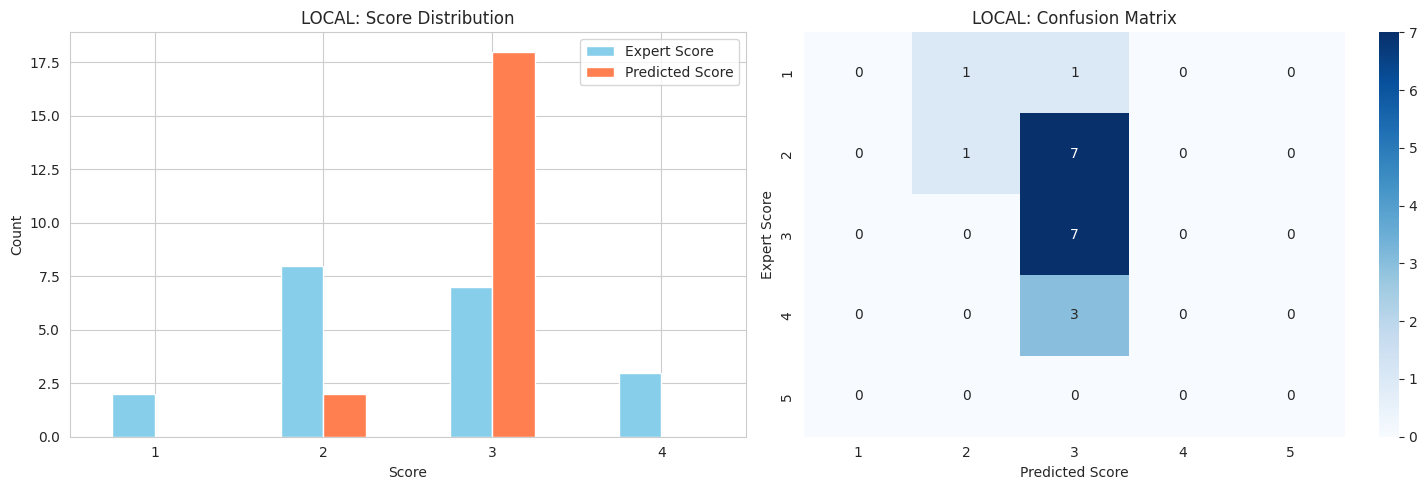

/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.50      0.12      0.20         8
           3       0.39      1.00      0.56         7
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0

    accuracy                           0.40        20
   macro avg       0.18      0.23      0.15        20
weighted avg       0.34      0.40      0.28        20



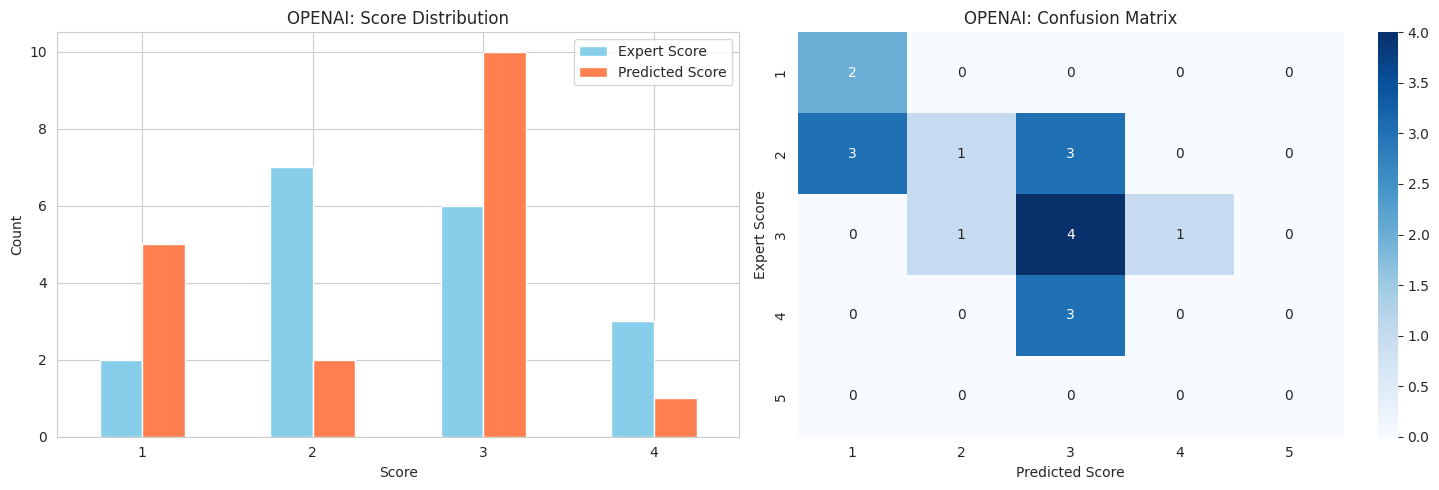

/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this


              precision    recall  f1-score   support

           1       0.40      1.00      0.57         2
           2       0.50      0.14      0.22         7
           3       0.40      0.67      0.50         6
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0

    accuracy                           0.39        18
   macro avg       0.26      0.36      0.26        18
weighted avg       0.37      0.39      0.32        18



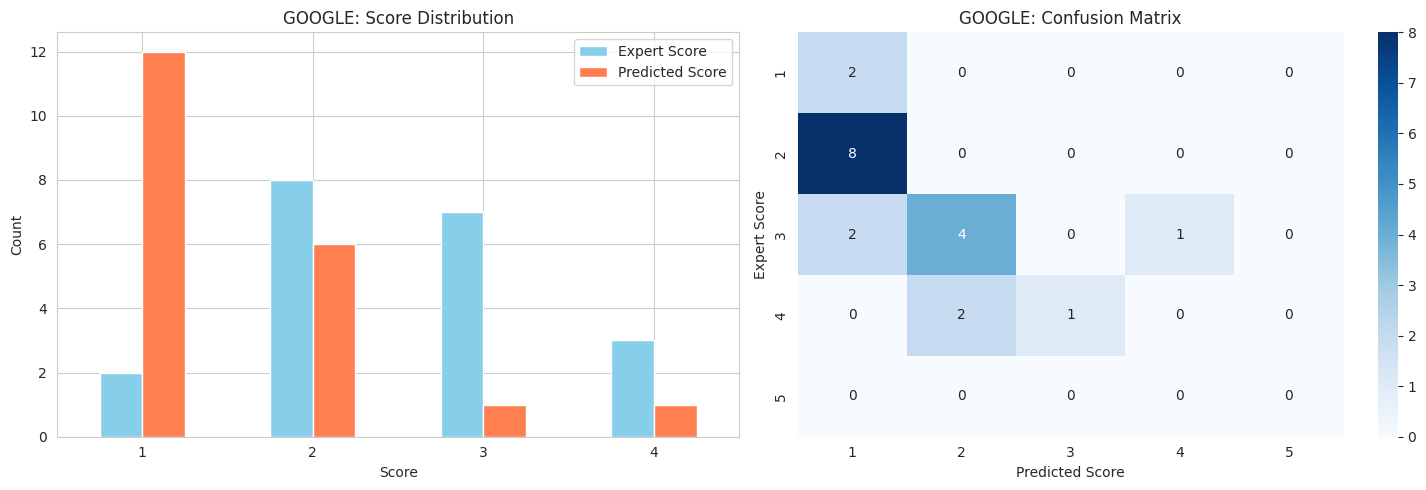

/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this


              precision    recall  f1-score   support

           1       0.17      1.00      0.29         2
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0

    accuracy                           0.10        20
   macro avg       0.03      0.20      0.06        20
weighted avg       0.02      0.10      0.03        20



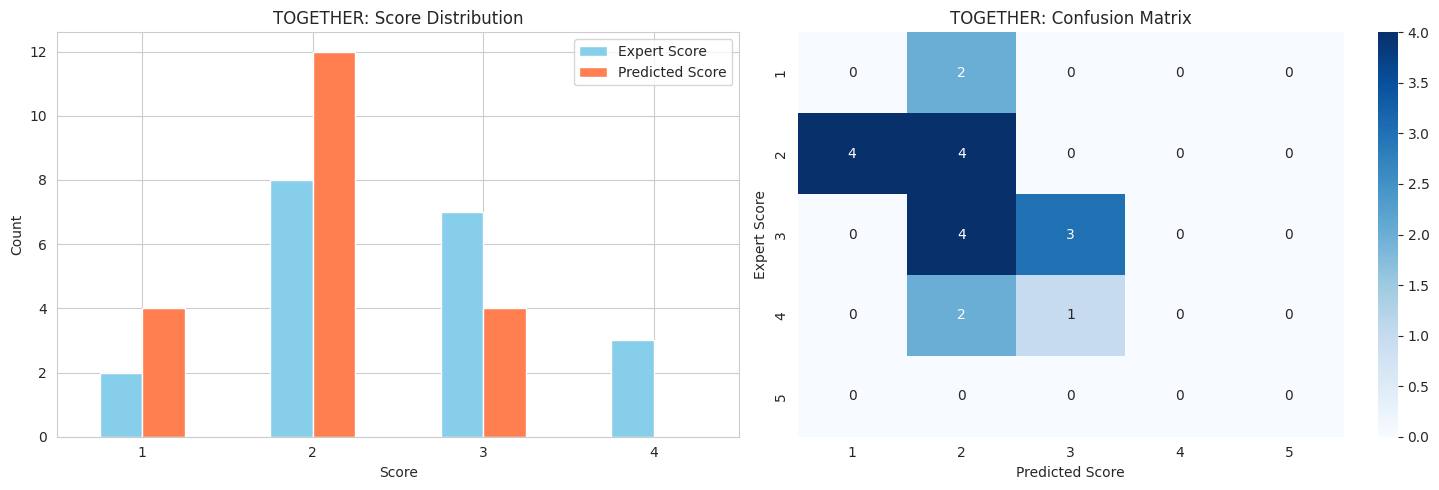


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.33      0.50      0.40         8
           3       0.75      0.43      0.55         7
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0

    accuracy                           0.35        20
   macro avg       0.22      0.19      0.19        20
weighted avg       0.40      0.35      0.35        20



/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/exouser/DSM-property-condition-assessment/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this

In [31]:
# Visualize predictions vs ground truth
for provider_name, results_df in results_by_provider.items():
    valid_df = results_df[results_df['predicted_score'].notna()].copy()
    
    if len(valid_df) == 0:
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Score distribution comparison
    expert_counts = valid_df['expert_score'].value_counts().sort_index()
    pred_counts = valid_df['predicted_score'].value_counts().sort_index()
    
    comparison = pd.DataFrame({
        'Expert Score': expert_counts,
        'Predicted Score': pred_counts
    }).fillna(0)
    
    comparison.plot(kind='bar', ax=axes[0], color=['skyblue', 'coral'])
    axes[0].set_title(f'{provider_name.upper()}: Score Distribution')
    axes[0].set_xlabel('Score')
    axes[0].set_ylabel('Count')
    axes[0].legend()
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    
    # Confusion matrix
    cm = confusion_matrix(valid_df['expert_score'], valid_df['predicted_score'], labels=[1,2,3,4,5])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    axes[1].set_title(f'{provider_name.upper()}: Confusion Matrix')
    axes[1].set_xlabel('Predicted Score')
    axes[1].set_ylabel('Expert Score')
    
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print(f"\n{classification_report(valid_df['expert_score'], valid_df['predicted_score'], labels=[1,2,3,4,5])}")


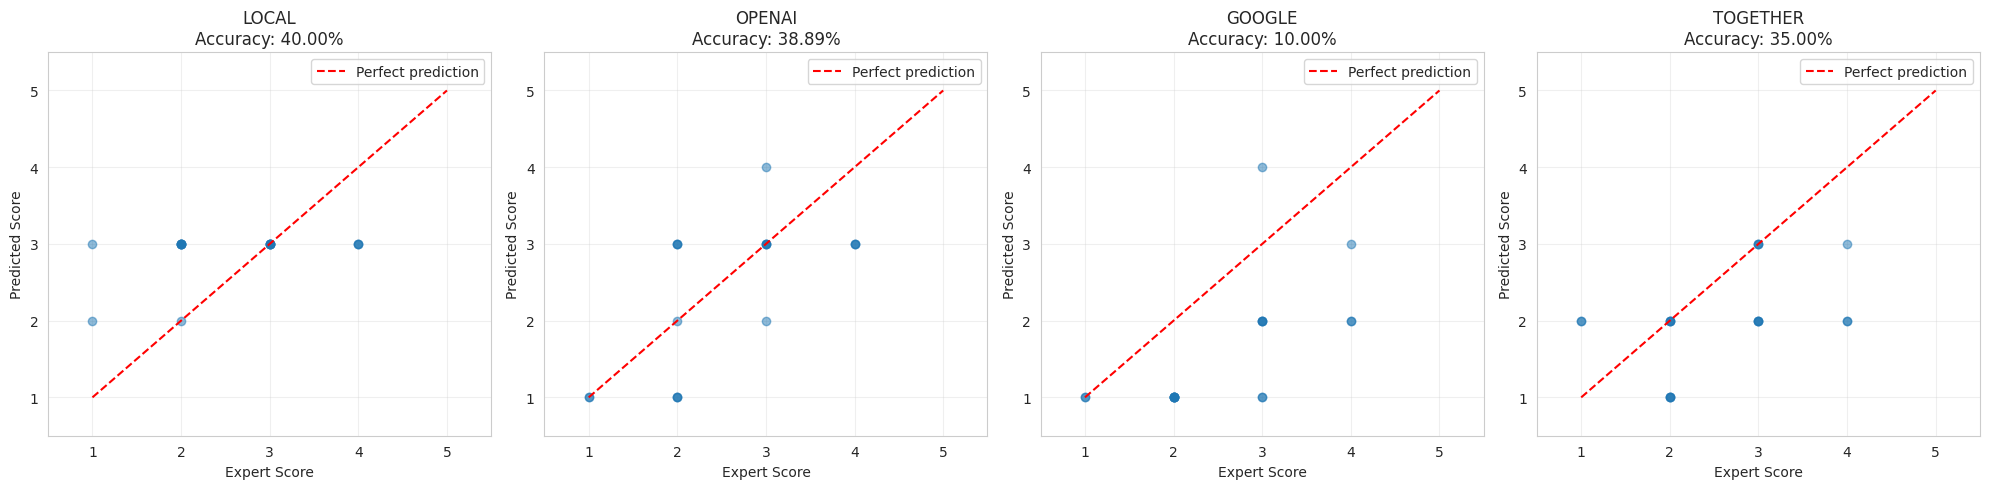

In [32]:
# Compare all providers side by side
if len(results_by_provider) > 1:
    fig, axes = plt.subplots(1, len(results_by_provider), figsize=(5*len(results_by_provider), 5))
    if len(results_by_provider) == 1:
        axes = [axes]
    
    for idx, (provider_name, results_df) in enumerate(results_by_provider.items()):
        valid_df = results_df[results_df['predicted_score'].notna()]
        
        if len(valid_df) > 0:
            # Scatter plot: predicted vs expert
            axes[idx].scatter(valid_df['expert_score'], valid_df['predicted_score'], alpha=0.5)
            axes[idx].plot([1, 5], [1, 5], 'r--', label='Perfect prediction')
            axes[idx].set_xlabel('Expert Score')
            axes[idx].set_ylabel('Predicted Score')
            axes[idx].set_title(f'{provider_name.upper()}\nAccuracy: {np.mean(valid_df["expert_score"] == valid_df["predicted_score"]):.2%}')
            axes[idx].legend()
            axes[idx].set_xlim(0.5, 5.5)
            axes[idx].set_ylim(0.5, 5.5)
            axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [33]:
# Save results
output_dir = Config.OUTPUTS_DIR
os.makedirs(output_dir, exist_ok=True)

for provider_name, results_df in results_by_provider.items():
    output_path = os.path.join(output_dir, f"zeroshot_scores_{provider_name}.csv")
    results_df.to_csv(output_path, index=False)
    print(f"✅ {provider_name} results saved to: {output_path}")


✅ local results saved to: data/outputs/zeroshot_scores_local.csv
✅ openai results saved to: data/outputs/zeroshot_scores_openai.csv
✅ google results saved to: data/outputs/zeroshot_scores_google.csv
✅ together results saved to: data/outputs/zeroshot_scores_together.csv


BUCKET-BASED ACCURACY ANALYSIS
Buckets: (1,2) -> Low, (3) -> Medium, (4,5) -> High

LOCAL:
  Exact Accuracy (5-class): 40.00%
  Bucket Accuracy (3-class): 45.00%
  Improvement: +5.00%

OPENAI:
  Exact Accuracy (5-class): 38.89%
  Bucket Accuracy (3-class): 55.56%
  Improvement: +16.67%

GOOGLE:
  Exact Accuracy (5-class): 10.00%
  Bucket Accuracy (3-class): 50.00%
  Improvement: +40.00%

TOGETHER:
  Exact Accuracy (5-class): 35.00%
  Bucket Accuracy (3-class): 65.00%
  Improvement: +30.00%



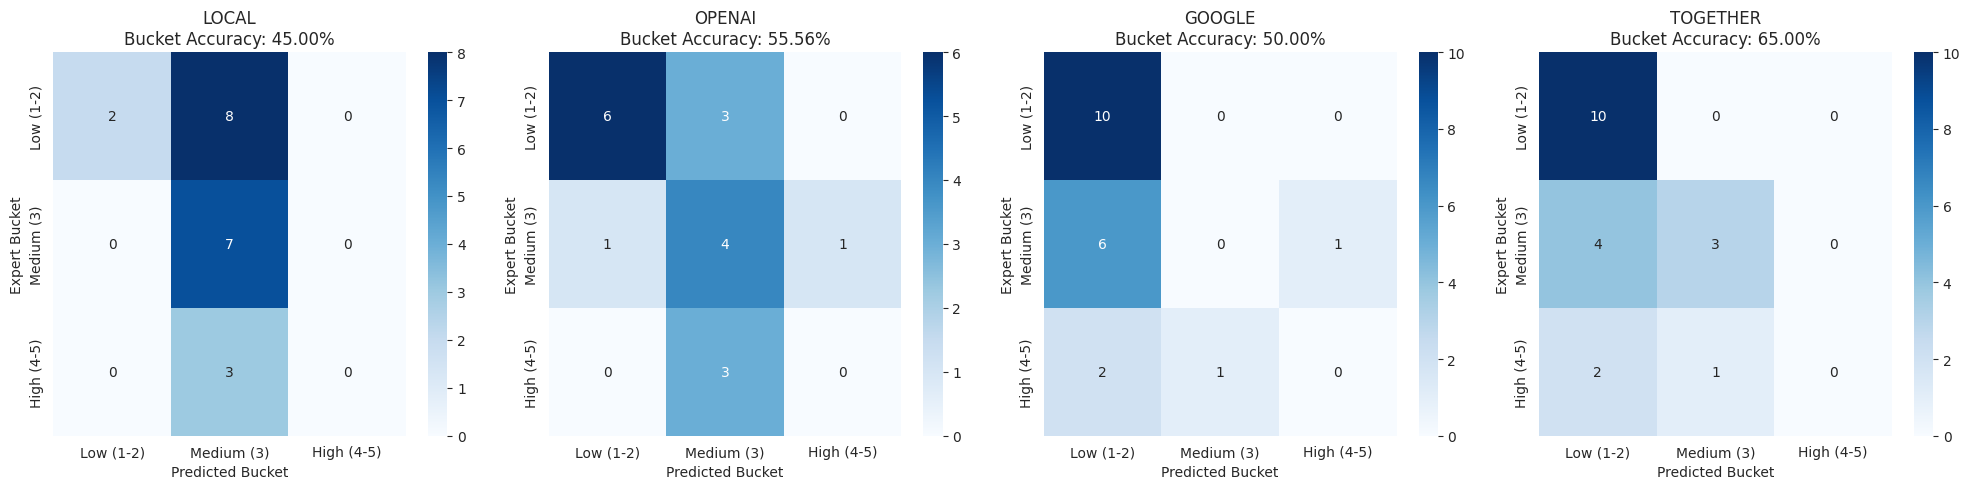

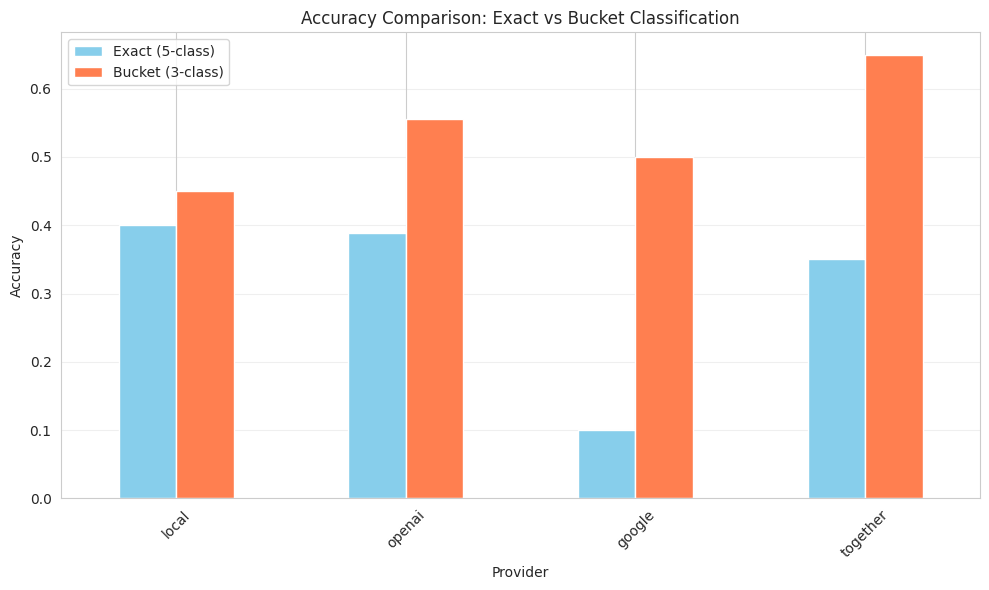

In [34]:
# Bucket-based Accuracy (Combined Classes)
# Map scores to buckets: (1,2) -> Low, (3) -> Medium, (4,5) -> High

def map_to_bucket(score):
    """Map score to bucket: 1,2 -> 1 (Low), 3 -> 2 (Medium), 4,5 -> 3 (High)"""
    if pd.isna(score):
        return None
    score = int(score)
    if score in [1, 2]:
        return 1  # Low/Healthy
    elif score == 3:
        return 2  # Medium/In-Between
    elif score in [4, 5]:
        return 3  # High/Unhealthy
    return None

# Calculate bucket-based accuracy for each provider
print("=" * 60)
print("BUCKET-BASED ACCURACY ANALYSIS")
print("=" * 60)
print("Buckets: (1,2) -> Low, (3) -> Medium, (4,5) -> High\n")

bucket_results = {}

for provider_name, results_df in results_by_provider.items():
    valid_df = results_df[results_df["predicted_score"].notna()].copy()
    
    if len(valid_df) == 0:
        continue
    
    # Map to buckets
    valid_df["expert_bucket"] = valid_df["expert_score"].apply(map_to_bucket)
    valid_df["predicted_bucket"] = valid_df["predicted_score"].apply(map_to_bucket)
    
    # Remove rows where bucket mapping failed
    valid_df = valid_df[valid_df["expert_bucket"].notna() & valid_df["predicted_bucket"].notna()]
    
    if len(valid_df) == 0:
        continue
    
    # Calculate bucket accuracy
    bucket_accuracy = np.mean(valid_df["expert_bucket"] == valid_df["predicted_bucket"])
    exact_accuracy = np.mean(valid_df["expert_score"] == valid_df["predicted_score"])
    
    bucket_results[provider_name] = {
        "df": valid_df,
        "bucket_accuracy": bucket_accuracy,
        "exact_accuracy": exact_accuracy
    }
    
    print(f"{provider_name.upper()}:")
    print(f"  Exact Accuracy (5-class): {exact_accuracy:.2%}")
    print(f"  Bucket Accuracy (3-class): {bucket_accuracy:.2%}")
    print(f"  Improvement: {bucket_accuracy - exact_accuracy:+.2%}\n")

# Visualize bucket-based confusion matrices
if len(bucket_results) > 0:
    fig, axes = plt.subplots(1, len(bucket_results), figsize=(5*len(bucket_results), 5))
    if len(bucket_results) == 1:
        axes = [axes]
    
    bucket_labels = ["Low (1-2)", "Medium (3)", "High (4-5)"]
    
    for idx, (provider_name, res) in enumerate(bucket_results.items()):
        valid_df = res["df"]
        cm = confusion_matrix(valid_df["expert_bucket"], valid_df["predicted_bucket"], labels=[1, 2, 3])
        
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx],
                    xticklabels=bucket_labels, yticklabels=bucket_labels)
        axes[idx].set_title(f"{provider_name.upper()}\nBucket Accuracy: {res['bucket_accuracy']:.2%}")
        axes[idx].set_xlabel("Predicted Bucket")
        axes[idx].set_ylabel("Expert Bucket")
    
    plt.tight_layout()
    plt.show()
    
    # Comparison bar chart
    comparison_data = pd.DataFrame({
        "Exact (5-class)": [res["exact_accuracy"] for res in bucket_results.values()],
        "Bucket (3-class)": [res["bucket_accuracy"] for res in bucket_results.values()]
    }, index=list(bucket_results.keys()))
    
    comparison_data.plot(kind="bar", figsize=(10, 6), color=["skyblue", "coral"])
    plt.title("Accuracy Comparison: Exact vs Bucket Classification")
    plt.ylabel("Accuracy")
    plt.xlabel("Provider")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    plt.show()